# Getting PubMed hits for the Query Institute

(Reported as affiliation in PubMed).

In [1]:
import requests
import xml.etree.ElementTree as ET

# Query institute
affiliation_string = 'Aligarh Muslim University'

# Fetch pubmed IDs for publications from the Affiliation-of-interest, as specified in the affiliation string
query = "%s[Affiliation]" % (affiliation_string) # Only mathcing the Affiliations.
esearch = 'http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pubmed&retmode=xml&retmax=10000000&sort=date&term=%s' % (query)

response = requests.get(esearch)

root = ET.fromstring(response.text)
pmid_list = [x.text for x in root.findall("IdList/Id")]

print('Got %d articles' % (len(pmid_list)))

Got 4624 articles


# Fetch individual publication info from PubMed from PMIDs fetched before

In [3]:
from Bio import Entrez
from Bio import Medline
import pandas as pd
import configs
Entrez.email = configs.email  # Use your email address.

# Fetch publication data from pubmed, using pmids as query.
medline_handle = Entrez.efetch(db="pubmed", id=f"{pmid_list}", rettype="medline", retmode='text')
medline_records = Medline.parse(medline_handle)
medline_records_list = list(medline_records)

medline_records_df = pd.DataFrame(medline_records_list)
print(f'Article info fecthed for : {medline_records_df.shape[0]} articles.')

Article info fecthed for : 4624 articles.


### Number of reviews in the dataset

In [4]:
(~medline_records_df.PT.astype(str).str.contains('Review')).sum()

4114

### Publications with MeSH tags

In [5]:
medline_records_df.MH.notna().sum()

3285

# WordCloud of MeSH tags (MH tags) [excluding reviews and null entries]

Rows to be plotted : 3285
Total words to plot in word cloud: 72181


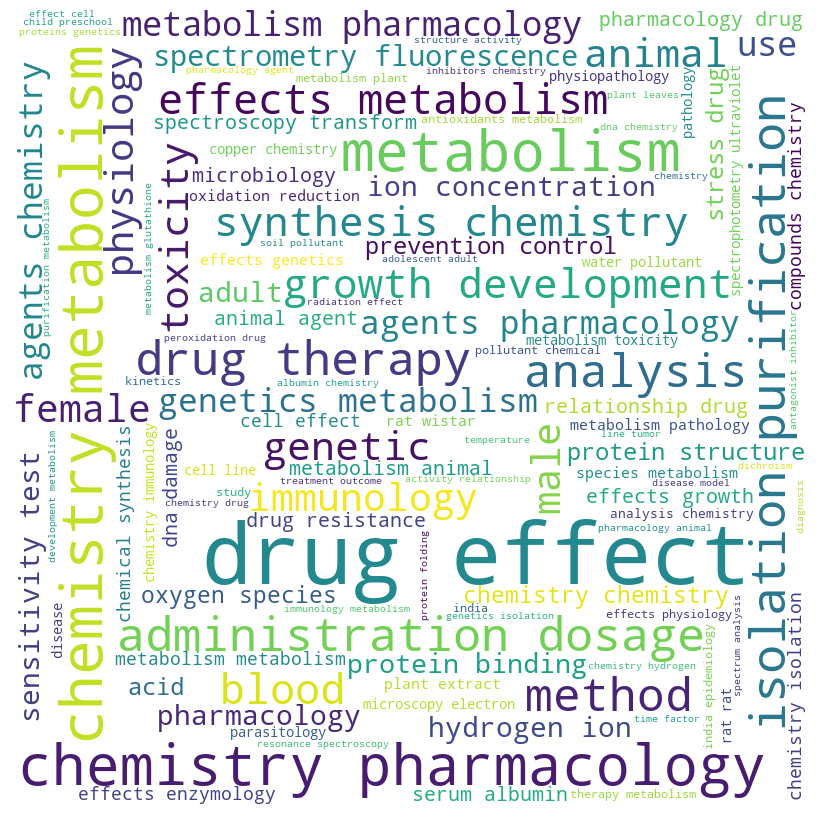

In [6]:
# Python program to generate WordCloud
# Relevant post: https://avidml.wordpress.com/2017/07/29/word-clouds-with-frequently-occurring-and-salient-unigrams/

# importing necessary modules
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd

# Defining excluded words
stopwords = set(STOPWORDS)

# Functions to plot word cloud.
def wc_plot_from_pd_series(pd_series, stopwords=set(STOPWORDS), comment_words= ''):
    """Plots world cloud from input pandas series with word strings. Optional stopwords and comment words can be
    defined, if some words are to be excluded from the word cloud/included in the word cloud.
    
    Input:
        pd_series: Pandas series with all word strings.
        stopwords: A set of stopwords to be excluded from the word cloud. Defaults to wordcloud set(STOPWORDS).
        comment_words: Defaults to empty string.
    
    Returns:
        Shows plot in jupyter notebook (but does not return the plot).
        Saves plot files named as queryAffiliation_dataframeName.png file (doses not return the image).
        comment_words: returns all words to be plotted as a string.       
    
    """
    
    # iterate through the csv file
    for val in pd_series:
        # typecaste each val to string
        val = str(val)
        val = val.replace('\'', '')

        import nltk
        WNL = nltk.WordNetLemmatizer()
        tokens = nltk.word_tokenize(val)
        tokens = [i.lower() for i in tokens]        # Convert all tokens/words into lowercase.
        tokens = [WNL.lemmatize(t) for t in tokens 
                 if t != 'species'] # Get lemma for each word; ex: The lemma of 'characters' is 'character'
        tags = nltk.pos_tag(tokens)                 # Get parts of speech (pos) for each tokens.
        nouns = [word for word,pos in tags if (pos == 'NN' or pos == 'NNP' or pos == 'NNS' or pos == 'NNPS')]
                                                    # Get only nouns for further analysis
        comment_words += " ".join(nouns)+" "
    tot_words_in_cloud = len(comment_words.split(' '))
    print(f'Total words to plot in word cloud: {tot_words_in_cloud}')
    wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)

    # plot the WordCloud image
    plt.figure(figsize = (10, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.savefig(f"{affiliation_string}_{df_to_plot.name}.png", dpi=700, format="png")
    plt.show()
    return comment_words

# WordCloud string to plot
import re
df_to_plot = medline_records_df.MH[medline_records_df.MH.notna()]
print(f'Rows to be plotted : {df_to_plot.shape[0]}')

# Plot the WordCloud, collect comment_words in case further analysis is warranted.
comment_words = wc_plot_from_pd_series(df_to_plot)

# WordCloud of Abstracts [excluding reviews and null entries]

Rows to be plotted : 2900
Total words to plot in word cloud: 200854


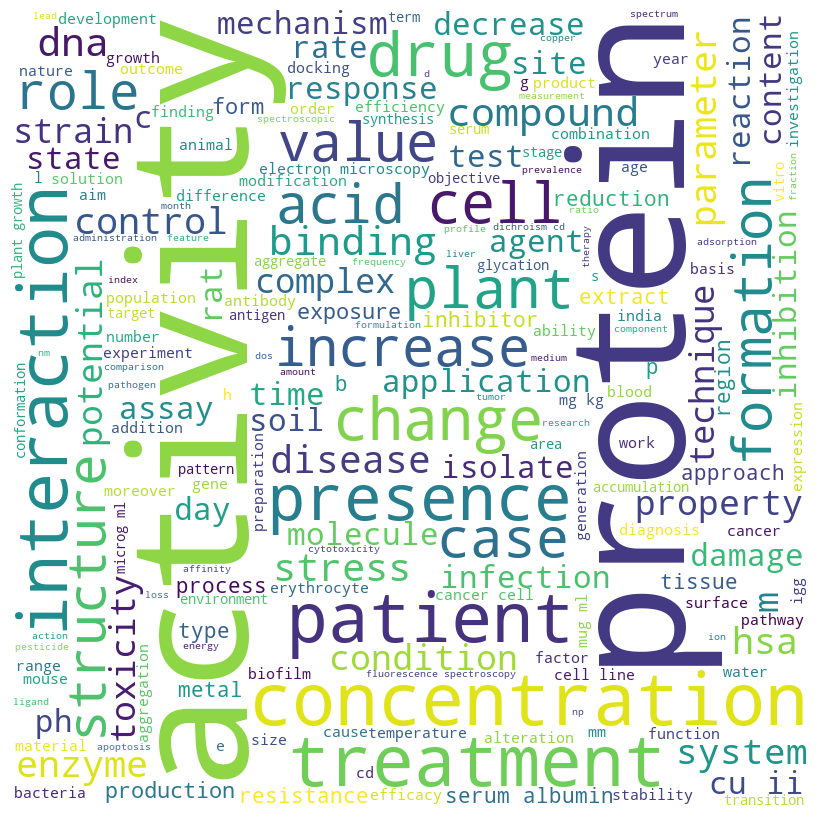

In [7]:
import re
df_to_plot = medline_records_df.AB[medline_records_df.MH.notna() & (~medline_records_df.PT.astype(str).str.contains('review', flags=re.IGNORECASE))]
print(f'Rows to be plotted : {df_to_plot.shape[0]}')

stopwords = set(STOPWORDS)
stopwords.update(['result', 'results','show', 'use', 'used', 'using', 'effect', 'sample', 'found', 'based',
                 'different', 'higher', 'conclusion', 'among', 'study', 'method','methods', 'level', 'levels',
                  'showed', 'background', 'compare', 'compared', 'conducted', 'group', 'respectively',
                 'one', 'two', 'three', 'four', 'data', 'analysis', 'model', 'revealed', 'significant',
                 'thus', 'whereas', 'overall', 'analyze', 'analyzed', 'identified', 'samples', 'associated',
                 'significantly', 'effects', '<', 'wa', 'ha'])
                # Stopwords are words that are exclduded from word cloud. I prepared this list before implementing
                # nltk pos noun selection (so, there are a lot of verbs). This list can probably be made smaller, if
                # needed. 
                # Point to note: was and has lemmatizes to wa and ha, respectively.

# Plot the WordCloud, collect comment_words in case further analysis is warranted.
comment_words = wc_plot_from_pd_series(df_to_plot, stopwords=stopwords)